# Projeto Controle Fuzzy PD para Quadricópteros

In [1]:
#!pip install -U scikit-fuzzy

In [2]:
import re                       # Suporte para expressões regulares.
import itertools                # Suporte para iterações em arrays.
import numpy as np              # Suporte para arrays e operações matemáticas.
import pandas as pd             # Suporte para manipulação de DataFrames.
import skfuzzy as fuzzy         # Suporte para operação com Lógica Fuzzy.
from tabulate import tabulate   # Suporte para manipulação de Tabelas.
import skfuzzy.control as ctrl  # Suporte para manipulação de Sistemas Fuzzy.
import matplotlib.pyplot as plt # Suporte para visualização de gráficos.

# Definição do universo das variáveis

Erro (𝑒):

Muito Pequeno (MP): O erro é muito pequeno, próximo do setPoint.

Pequeno (P): O erro é pequeno, distância pequena do setPoint.

Médio (M): O erro está moderado, distância intermediária do setPoint.

Grande (G): O erro é grande, distância alta do setPoint.

Muito Grande (MG): O erro é muito grande, muito longe do setPoint.


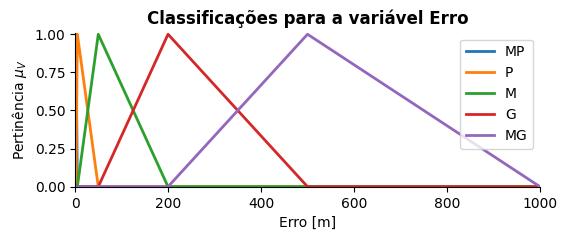

In [12]:
# Definição da variável Antecedente Erro 0:1000 m
Erro = ctrl.Antecedent(universe=np.arange(0, 1001, 1), label='Erro')

# Classificações de Erro
Erro['MP'] = fuzzy.trimf(Erro.universe, [0, 2, 5])
Erro['P'] = fuzzy.trimf(Erro.universe, [2, 5, 50])
Erro['M'] = fuzzy.trimf(Erro.universe, [5, 50, 200])
Erro['G'] = fuzzy.trimf(Erro.universe, [50, 200, 500])
Erro['MG'] = fuzzy.trimf(Erro.universe, [200, 500, 1000])

Erro.view()   # Método para visualização da Função de Pertinência.
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel=f'{Erro.label} [m]'); axes.set_ylabel(ylabel=r'Pertinência $\mu_{V}$')
plt.title(f'Classificações para a variável {Erro.label}', fontweight='bold'); plt.legend(loc='upper right')

Variação do Erro (Δ𝑒):

Muito Pequena (MP): A variacao do erro é muito pequena.

Pequena (P): A variacao do erro é pequena.

Médio (M): A variacao do erro é intermediária.

Grande (G): A variacao do erro é grande.

Muito Grande (MG): A variacao do erro é muito grande.

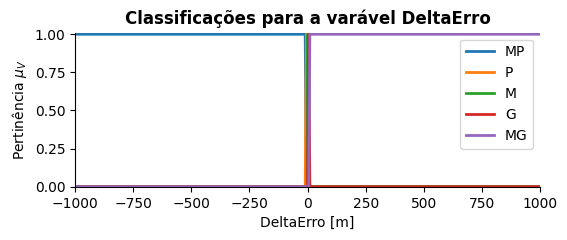

In [4]:
# Definição da variável Antecedente DeltaErro -1000:1000 m
DeltaErro = ctrl.Antecedent(universe=np.arange(-1000, 1001, 1), label='DeltaErro')

# Classificações de DeltaErro
DeltaErro['MP'] = fuzzy.trapmf(DeltaErro.universe, [-1000, -1000, -10, -5])
DeltaErro['P'] = fuzzy.trimf(DeltaErro.universe, [-10, -5, 0])
DeltaErro['M'] = fuzzy.trimf(DeltaErro.universe, [-2, 0, 2])
DeltaErro['G'] = fuzzy.trimf(DeltaErro.universe, [0, 5, 10])
DeltaErro['MG'] = fuzzy.trapmf(DeltaErro.universe, [5, 10, 1000, 1000])

DeltaErro.view()   # Método para visualização da Função de Pertinência.
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel='DeltaErro [m]'); axes.set_ylabel(ylabel=r'Pertinência $\mu_{V}$');
plt.title(f'Classificações para a varável {DeltaErro.label}', fontweight='bold'); plt.legend(loc='upper right');

Potência do Motor (𝑃𝑀𝑜𝑡𝑜𝑟):

Muito Baixa (MB): Potência muito baixa.

Baixa (B): Potência baixa.

Média (M): Potência média.

Alta (A): Potência alta.

Muito Alta (MA): Potência muito alta.


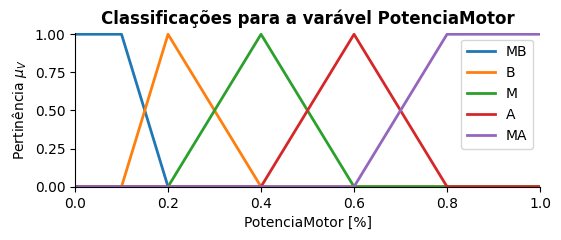

In [5]:
# Definição da variável Consequente PotenciaMotor 0:1
PotenciaMotor = ctrl.Consequent(universe=np.arange(0, 1.01, 0.01), label='PotenciaMotor')

# Classificações de PotenciaMotor
PotenciaMotor['MB'] = fuzzy.trapmf(PotenciaMotor.universe, [0, 0, 0.1, 0.2])
PotenciaMotor['B'] = fuzzy.trimf(PotenciaMotor.universe, [0.1, 0.2, 0.4])
PotenciaMotor['M'] = fuzzy.trimf(PotenciaMotor.universe, [0.2, 0.4, 0.6])
PotenciaMotor['A'] = fuzzy.trimf(PotenciaMotor.universe, [0.4, 0.6, 0.8])
PotenciaMotor['MA'] = fuzzy.trapmf(PotenciaMotor.universe, [0.6, 0.8, 1.0, 1.0])

PotenciaMotor.view()   # Método para visualização da Função de Pertinência.
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel='PotenciaMotor [%]'); axes.set_ylabel(ylabel=r'Pertinência $\mu_{V}$');
plt.title(f'Classificações para a varável {PotenciaMotor.label}', fontweight='bold'); plt.legend(loc='upper right');

# Base de Regras

In [6]:
# Base de Regras
BaseRegras = [
    ctrl.Rule(Erro['MP'] & DeltaErro['MP'], PotenciaMotor['MB']),
    ctrl.Rule(Erro['MP'] & DeltaErro['P'], PotenciaMotor['MB']),
    ctrl.Rule(Erro['MP'] & DeltaErro['M'], PotenciaMotor['B']),
    ctrl.Rule(Erro['MP'] & DeltaErro['G'], PotenciaMotor['M']),
    ctrl.Rule(Erro['MP'] & DeltaErro['MG'], PotenciaMotor['A']),
    
    ctrl.Rule(Erro['P'] & DeltaErro['MP'], PotenciaMotor['MB']),
    ctrl.Rule(Erro['P'] & DeltaErro['P'], PotenciaMotor['B']),
    ctrl.Rule(Erro['P'] & DeltaErro['M'], PotenciaMotor['B']),
    ctrl.Rule(Erro['P'] & DeltaErro['G'], PotenciaMotor['M']),
    ctrl.Rule(Erro['P'] & DeltaErro['MG'], PotenciaMotor['A']),
    
    ctrl.Rule(Erro['M'] & DeltaErro['MP'], PotenciaMotor['B']),
    ctrl.Rule(Erro['M'] & DeltaErro['P'], PotenciaMotor['B']),
    ctrl.Rule(Erro['M'] & DeltaErro['M'], PotenciaMotor['M']),
    ctrl.Rule(Erro['M'] & DeltaErro['G'], PotenciaMotor['M']),
    ctrl.Rule(Erro['M'] & DeltaErro['MG'], PotenciaMotor['A']),
    
    ctrl.Rule(Erro['G'] & DeltaErro['MP'], PotenciaMotor['M']),
    ctrl.Rule(Erro['G'] & DeltaErro['P'], PotenciaMotor['M']),
    ctrl.Rule(Erro['G'] & DeltaErro['M'], PotenciaMotor['M']),
    ctrl.Rule(Erro['G'] & DeltaErro['G'], PotenciaMotor['A']),
    ctrl.Rule(Erro['G'] & DeltaErro['MG'], PotenciaMotor['A']),
    
    ctrl.Rule(Erro['MG'] & DeltaErro['MP'], PotenciaMotor['A']),
    ctrl.Rule(Erro['MG'] & DeltaErro['P'], PotenciaMotor['A']),
    ctrl.Rule(Erro['MG'] & DeltaErro['M'], PotenciaMotor['A']),
    ctrl.Rule(Erro['MG'] & DeltaErro['G'], PotenciaMotor['A']),
    ctrl.Rule(Erro['MG'] & DeltaErro['MG'], PotenciaMotor['MA'])
]



In [7]:
ciano = '\033[96m'  # Define a cor azul-ciano

tabela = []
for erro in Erro.terms:  # Itera sobre os termos de classificação da variável Erro.
    for deltaErro in DeltaErro.terms:  # Itera sobre os termos de classificação da variável DeltaErro.
        for regra in BaseRegras:  # Itera sobre todas as regras da base.
            antecedente = str(regra).split('IF ')[1].split(' THEN')[0].replace('AND ', '')
            consequente = str(regra).split('IF ')[1].split(' THEN')[1].split('AND ')[0]

            # Encontra os classificadores (termos fuzzy) no texto da regra.
            classificacoes = re.findall(r'\[(.*?)\]', (antecedente + consequente))
            if erro == classificacoes[0] and deltaErro == classificacoes[1]:
                tabela.append([classificacoes[0], classificacoes[1], classificacoes[2]])
                break

# Cria um DataFrame com os dados da tabela.
df = pd.DataFrame(tabela, columns=[Erro.label, DeltaErro.label, PotenciaMotor.label])

# Cria a tabela pivô para organização visual.
pivotTable = pd.DataFrame(df.pivot(index=DeltaErro.label, columns=Erro.label, values=PotenciaMotor.label)
                          .reindex(index=DeltaErro.terms, columns=Erro.terms))

# Nomeia o índice e aplica formatação colorida.
pivotTable.index.name = f"{ciano}E\033[0m"

# Exibe a tabela formatada.
print(tabulate(pivotTable, headers='keys', tablefmt='fancy_grid', stralign='center', showindex='always'), end='\n\n')


╒═════╤══════╤═════╤═════╤═════╤══════╕
│  E  │  MP  │  P  │  M  │  G  │  MG  │
╞═════╪══════╪═════╪═════╪═════╪══════╡
│ MP  │  MB  │ MB  │  B  │  M  │  A   │
├─────┼──────┼─────┼─────┼─────┼──────┤
│  P  │  MB  │  B  │  B  │  M  │  A   │
├─────┼──────┼─────┼─────┼─────┼──────┤
│  M  │  B   │  B  │  M  │  M  │  A   │
├─────┼──────┼─────┼─────┼─────┼──────┤
│  G  │  M   │  M  │  M  │  A  │  A   │
├─────┼──────┼─────┼─────┼─────┼──────┤
│ MG  │  A   │  A  │  A  │  A  │  MA  │
╘═════╧══════╧═════╧═════╧═════╧══════╛



# Definindo uma regra qualquer e observando como ela é interpretada.


Graus de pertinência para Erro:
  - M: 0.67
  - G: 0.33

Graus de pertinência para DeltaErro:
  - G: 0.40

Classificações da variável de saída (PotenciaMotor):
  - M: 0.54
  - A: 0.46

Valor final da PotenciaMotor: 0.49%


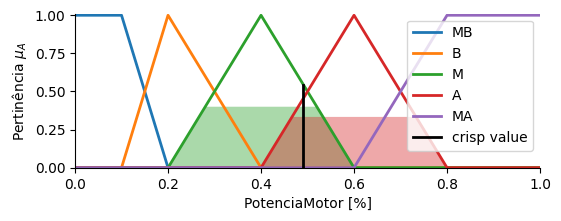

In [13]:
# Configurando o sistema de controle
ControleErro = ctrl.ControlSystemSimulation(ctrl.ControlSystem(BaseRegras))

# Definindo entradas para Erro e DeltaErro
ControleErro.input[Erro.label] = 100  # valor desejado para Erro
ControleErro.input[DeltaErro.label] = 2  # valor desejado para DeltaErro

# Realiza o cálculo do sistema fuzzy
ControleErro.compute()

# Graus de pertinência para a variável Erro
print(f"\nGraus de pertinência para {Erro.label}:")
ativacaoErro = []  # Lista de regiões ativadas para o Erro
for erro_nome, erro_mf in Erro.terms.items():
    uV = fuzzy.interp_membership(Erro.universe, erro_mf.mf, ControleErro._get_inputs()[Erro.label])
    if uV > 0:
        print(f"  - {erro_nome}: {uV:.2f}")
        ativacaoErro.append(erro_nome)

# Graus de pertinência para a variável DeltaErro
print(f"\nGraus de pertinência para {DeltaErro.label}:")
ativacaoDeltaErro = []  # Lista de regiões ativadas para o DeltaErro
for delta_nome, delta_mf in DeltaErro.terms.items():
    uI = fuzzy.interp_membership(DeltaErro.universe, delta_mf.mf, ControleErro._get_inputs()[DeltaErro.label])
    if uI > 0:
        print(f"  - {delta_nome}: {uI:.2f}")
        ativacaoDeltaErro.append(delta_nome)

# Valor da variável de saída (PotenciaMotor)
print(f"\nClassificações da variável de saída ({PotenciaMotor.label}):")
for termo_nome, termo_mf in PotenciaMotor.terms.items():
    uA = fuzzy.interp_membership(PotenciaMotor.universe, termo_mf.mf, ControleErro.output[PotenciaMotor.label])
    if uA > 0:
        print(f"  - {termo_nome}: {uA:.2f}")

# Exibição gráfica da saída
PotenciaMotor.view(sim=ControleErro)
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel=f"{PotenciaMotor.label} [%]"); axes.set_ylabel(ylabel=r"Pertinência $\mu_{A}$")
plt.legend(loc='upper right')

# Resultado final da Potência do Motor
print(f"\nValor final da {PotenciaMotor.label}: {ControleErro.output[PotenciaMotor.label]:.2f}%")


### Resultados para setpoint = 200 m e posição_atual = 800 m

In [ ]:
setpoint = 200  # Altitude desejada (em metros)
d_t_minus_1 = 400  # posição atual do drone, em metros
tempo = 50  # Tempo de simulação (em segundos)
dt = 1  # Intervalo de tempo (em segundos)

# Parâmetros do sistema fuzzy
FA = 0.9  # Fator de Ajuste
U_max = 4  # Velocidade máxima de descida (m/s)

# Valores para armazenar deslocamentos e erros
deslocamentos = [d_t_minus_1]
erros = [setpoint - d_t_minus_1]

for t in range(1, tempo + 1):
    # Calcular o erro
    erro_atual = setpoint - d_t_minus_1
    erros.append(erro_atual)

    delta_erro_atual = (erros[-1] - erros[-2]) / dt  # Taxa de variação do erro

    # Configurar entradas do sistema fuzzy
    ControleErro.input['Erro'] = erro_atual
    ControleErro.input['DeltaErro'] = delta_erro_atual

    # Realizar o cálculo fuzzy
    ControleErro.compute()

    # Obter a saída defuzzyficada (potência do motor)
    P_Motor = ControleErro.output['PotenciaMotor']

    # Divisão da potência entre os motores
    P_H13 = P_Motor
    P_H24 = P_Motor

    # Atualizar o deslocamento com a função de transferência
    d_t = FA * d_t_minus_1 * 1.01398 + (0.5 * (U_max * (P_H13 / 100) + U_max * (P_H24 / 100)))
    deslocamentos.append(d_t)

    # Atualizar o deslocamento anterior
    d_t_minus_1 = d_t

# Gráficos
plt.figure(figsize=(10, 5))

# Gráfico do deslocamento
plt.subplot(1, 2, 1)
plt.plot(range(len(deslocamentos)), deslocamentos, label='Deslocamento (m)', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label='Setpoint')
plt.xlabel('Tempo (s)')
plt.ylabel('Deslocamento (m)')
plt.title('Deslocamento do Drone ao Longo do Tempo')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'PotenciaMotor'